In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp /content/drive/MyDrive/mnist.pkl.gz /content/mnist.pkl.gz
!cp /content/drive/MyDrive/dataset_loader.py /content/dataset_loader.py

# Deep Probabilistice Generative Models - Variational Auto-Encoders


## 0. Preprocessing

Import the libraries we will use.
You can download the file dataset_loader from the course website.

In [4]:
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
import math

import dataset_loader

%matplotlib inline

Next, we download and preprocess the MNIST dataset, see http://yann.lecun.com/exdb/mnist/ .
Our observed random variables will be Bernoulli distributions, so we need to binarize the dataset, i.e. each pixel can either be black or white.

In [5]:
mnist_path = "/content/mnist.pkl.gz"

# the dataset contains 3 splits (train/dev/test),
# each one containing two vectors (pixels and classes)
(train_data_pixels, train_data_classes), \
(dev_data_pixels, dev_data_classes), _ = dataset_loader.load_mnist(mnist_path)

In [6]:
# to binarize, we just set to 1 pixels with a value >= 0.5, 0 otherwise
train_data_pixels = 1*(train_data_pixels >= 0.5)
dev_data_pixels = 1*(dev_data_pixels >= 0.5)

In [7]:
# dataset_loader return numpy tensors,
# we convert them directly to pytorch tensors
train_data_pixels = torch.from_numpy(train_data_pixels).float()
train_data_classes = torch.from_numpy(train_data_classes).long()

dev_data_pixels = torch.from_numpy(dev_data_pixels).float()
dev_data_classes = torch.from_numpy(dev_data_classes).long()

In [8]:
# there 50000 images, each image is of size 28x28
# each image as been reshaped as vector of size 784
print("Shape of the pixel tensor:", train_data_pixels.shape)
print("Shape of the class tensor:", train_data_classes.shape)

Shape of the pixel tensor: torch.Size([50000, 784])
Shape of the class tensor: torch.Size([50000])


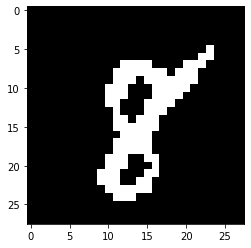

In [9]:
# we will use this function to print images generated by our network
# the parameter images must be a tensor of shape (n images, 784)
def display_images(images):
    # convert to numpy tensor
    images = images.detach().numpy()

    for i in range(images.shape[0]):
        plt.imshow(images[i].reshape(28,28), cmap='gray')
        plt.show()
        
# display the 5 first image in the dataset
display_images(train_data_pixels[:1])

## 2. VAE with continuous latent space and binary observed space

The first VAE that we will develop is based on the following generative story:

1. $z \sim p(z)$
2. $x \sim p(x | z ; \theta)$

where the latent random variable $Z$ takes value in $\mathbb R^n$.
The prior ditribution $p(z)$ is a multivariate Gaussian where each coordinate is independent.
We fix the mean and variance of each coordinate to 0 and 1, respectively.
The conditional distribution $p(x | z ; \theta)$ is parameterized by a neural network.
The random variables $X$ are $m$ independent Bernoulli random variables.

Note: this kind of VAE will be quite bad at generating MNIST picture.
Therefore, when you do you experiments, you should both generate picture and show the distribution $p(x | z ; \theta)$ as a picture.
This is a well known problem of VAE, you can try to play with the network architecture and the parameters to improve generation.
However, hyperparameter optimization is not the goal of this lab exercise. :)
Another solution would be to use Gaussian random variables for the output distribution, but we won't do that here.

### KL divergence

The first function we have to implement is the one that compute the KL divergence with the prior.
You can find the formula in appendix B of the following paper: https://arxiv.org/pdf/1312.6114.pdf

**WARNING:** In the paper they give the formula for the -KL, and here we want the KL, so don't forget to put a minus sign in front of their formula. :)

In [13]:
# the shapes of mu and log_sigma_squared are: (n batch, n latent)
# the return vector must be of shape: (n batch,)
def KL_with_gaussian_prior(mu, log_sigma_squared):
    s = torch.exp(0.5*log_sigma_squared)
    KL = -0.5 * torch.sum(1 + torch.log(s*s) - mu*mu - s*s , axis = 1)
    return KL
    
# test for shape
mu = torch.rand((10, 30))
log_sigma_squared = torch.rand((10, 30))

if KL_with_gaussian_prior(mu, log_sigma_squared).shape != (10, ):
    raise RuntimeError("Invalid return dim!")
else:
    print("return dim is ok.")
    
# test for return value
# result should be 0 as it is equal to the prior
print("Should be 0:", KL_with_gaussian_prior(torch.tensor([[0.]]), torch.tensor([[0.]])).item())
print("Should be 0.5:", KL_with_gaussian_prior(torch.tensor([[1.]]), torch.tensor([[0.]])).item())
print("Should be 2.6945...:", KL_with_gaussian_prior(torch.tensor([[1.]]), torch.tensor([[2.]])).item())

return dim is ok.
Should be 0: -0.0
Should be 0.5: 0.5
Should be 2.6945...: 2.6945278644561768


### Network


In [14]:
class GaussianEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.proj1 = nn.Linear(input_dim, hidden_dim)

        self.proj1Mu = nn.Linear(hidden_dim,hidden_dim)
        self.proj2Mu = nn.Linear(hidden_dim, output_dim)

        self.proj1Sigma = nn.Linear(hidden_dim, hidden_dim)
        self.proj2Sigma = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, batch):
        hid = self.proj1(batch)

        hidMu1 = self.proj1Mu(F.relu(hid))
        outMu = self.proj2Mu(hidMu1)

        hidSigma1 = self.proj1Sigma(F.relu(hid))
        outSigma = self.proj2Sigma(hidSigma1)

        return (outMu,outSigma)

In [15]:
class GaussianPriorDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.proj1Mu = nn.Linear(hidden_dim,output_dim)
        
    def forward(self, batch):
        hid = F.relu(self.proj1(batch))
        return self.proj1Mu(hid)
    
    # n_samples: number of "image output distribution" to compute
    def sample_distributions(self, n_samples):
        # first you must sample from the prior,
        # then you must pass the data through this network, i.e. self(z)
        
        # shape of z: (n_samples, input_dim)
        z = torch.empty(n_samples, self.input_dim) 
        z = z.normal_()
        return torch.sigmoid(self(z))

    # sample images
    def sample_images(self, n_samples, argmax=False):
        # compute the output distributions for each image
        # probs shae: (n_samples, output_dim)
        probs = self.sample_distributions(n_samples)
        
        # then sample output pixels
        # there are two modes:
        # argmax=False: sample from the output distribution
        # argmax=True: instead of sampling, return the most probable value for each random variable
        # (check how the images are converted to binary images above!)
        if argmax == False:
            return torch.bernoulli(probs)
        elif argmax == True:
            return 1*(probs >= 0.5)

### Training loop

I did most of the work, you just need to implement ont thing: the reparameterization trick! :)

In [16]:
dim_input = 28*28
latent_dim = 2 # we use only 2 dimensions so we can plot them!
hidden_dim = 400
n_epoch = 30
batch_dim = 256

encoder = GaussianEncoder(dim_input, hidden_dim, latent_dim)
decoder = GaussianPriorDecoder(latent_dim, hidden_dim, dim_input)

kl_div_1 = []
recons_1 = []
# we must pass both network parameters to the optimizer
# sometime its also useful to use two different optimizers,
# for example if we want to use different learning rates.
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0

    decoder.train()
    encoder.train()
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        optimizer.zero_grad()
        
        batch = train_data_pixels[i:i+batch_dim]
        
        # compute parameters of the approximate posterior
        mu, log_sigma_squared = encoder(batch)
        # for MC sampling of the reconstruction loss,
        # we use one sample from the approximate posterior.
        # you need to use the reparameterization trick for this!
        # in order to sample from the the N(0, 1) distribution,
        # you can use:
        # torch.empty_like(mu).normal_(mean=0.,std=1.)
        # (check the documentation if you don't understand this!)
        sigma = torch.exp(0.5*log_sigma_squared)

        e = torch.empty_like(mu).normal_(mean=0.,std=1.)
        z = mu + e*sigma
        
        # reconstruction_logits: (batches, classes, output size)
        # note that the output of the network is in R,
        # to get Bernoulli parameters you must use the sigmoid.
        # For the reconstruction loss, you can either use:
        # - F.binary_cross_entropy_with_logits
        # - F.entropy_with_logits
        # Read the doc in order to understand the difference!
        # Warning: use the reduction="none" parameter
        reconstruction_logits = decoder(z)
        reconstruction_loss = F.binary_cross_entropy_with_logits(
            reconstruction_logits,
            batch,
            reduction="none"
        )
        
        kl_div = KL_with_gaussian_prior(mu, log_sigma_squared)
        
        # loss shape: (batch dim,)
        # do you understand why we sum along this dimension only?
        # there is a minus sign before reconstruction because
        # the loss formula is -log etc, but in the elbo its +log
        elbo = -reconstruction_loss.sum(1) - kl_div 
        epoch_reconstruction += -reconstruction_loss.sum().item()
        epoch_kl += kl_div.sum().item()
        
        # we want to maximize the ELBO,
        # but Pytorch does minimization,
        # so we define our loss as -ELBO
        # and we mean over instances in the dataset
        loss = -elbo.mean()
        loss.backward()
        
        # optimization trick :)
        # gradient clipping, so we don't take too big updates
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        
        optimizer.step()
        
    print(
        epoch, ":\t",
        epoch_reconstruction / train_data_pixels.shape[0],
        "\t",
        epoch_kl / train_data_pixels.shape[0]
    )
    # We save values of kl divergence and recons loss to plot them later.
    kl_div_1.append(kl_div.sum().item())
    recons_1.append(-reconstruction_loss.sum().item())

0 :	 -189.12220966796875 	 6.993306557071209
1 :	 -160.837228046875 	 5.1905480261230466
2 :	 -155.7834204296875 	 5.438548774414063
3 :	 -152.8785019140625 	 5.603801464233398
4 :	 -150.91018046875 	 5.685793509521484
5 :	 -149.33504689453125 	 5.779176662597656
6 :	 -148.03928994140625 	 5.833537736816406
7 :	 -147.0204315234375 	 5.8736759979248045
8 :	 -146.11655279296875 	 5.925756340942383
9 :	 -145.33300265625 	 5.953775205078125
10 :	 -144.59079734375 	 5.974429806518555
11 :	 -143.958248828125 	 6.009728517456055
12 :	 -143.40874775390625 	 6.040391532592773
13 :	 -142.8637579296875 	 6.0711280859375
14 :	 -142.42408244140626 	 6.09349139465332
15 :	 -141.94423833984376 	 6.116466829223633
16 :	 -141.5192190625 	 6.133612613525391
17 :	 -141.19043875 	 6.16972056640625
18 :	 -140.86133033203126 	 6.186939053955078
19 :	 -140.55688091796875 	 6.1769547344970706
20 :	 -140.122302890625 	 6.236030604248047
21 :	 -139.88640513671876 	 6.2263214178466795
22 :	 -139.556831328125 	 6

We can now visualize the output distribution from random prior samples and generate new images.

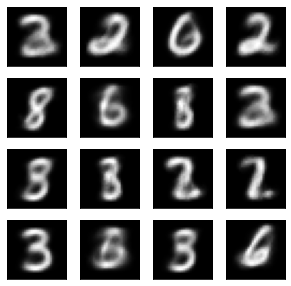

In [17]:
decoder.eval()

fig , axs = plt.subplots(4,4, figsize = (5,5))
with torch.no_grad():
    samples = decoder.sample_distributions(4*4)
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(samples.detach().view(-1,28,28).numpy()[i*4+j], cmap='gray')
            axs[i,j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

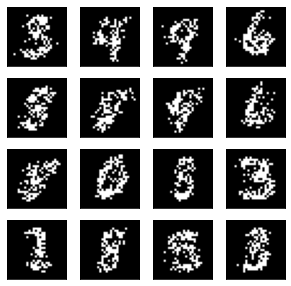

In [18]:
decoder.eval()

fig , axs = plt.subplots(4,4, figsize = (5,5))
with torch.no_grad():
    samples = decoder.sample_images(4*4, argmax=False)
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(samples.detach().view(-1,28,28).numpy()[i*4+j], cmap='gray')
            axs[i,j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

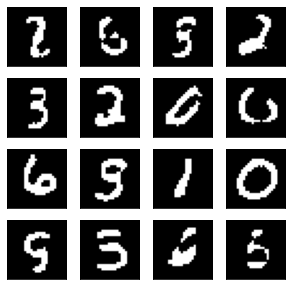

In [19]:
decoder.eval()

fig , axs = plt.subplots(4,4, figsize = (5,5))
with torch.no_grad():
    samples = decoder.sample_images(4*4, argmax=True)
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(samples.detach().view(-1,28,28).numpy()[i*4+j], cmap='gray')
            axs[i,j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

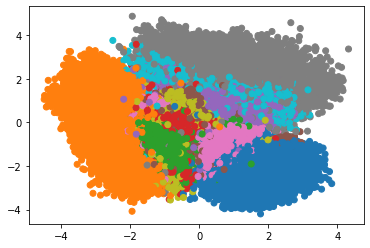

In [20]:
encoder.eval()

# tensor that will contain all latent points
points = np.empty((train_data_pixels.shape[0], 2))
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        batch = train_data_pixels[i:i+batch_dim]
        mu, _ = encoder(batch)
        points[i:i+batch_dim] = mu.numpy()

plt.scatter(
    points[:,0], points[:, 1],
    # colormap is between 0 and 1, and we have 10 classes
    # so we just divide by 10 :)
    # https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
    c=matplotlib.cm.get_cmap("tab10")(train_data_classes.numpy() / 10.)
)
plt.show()

## 3. VAE with binary latent space and binary observed space

The second VAE that we will develop is based on the same generative story:

1. $z \sim p(z)$
2. $x \sim p(x | z ; \theta)$

but where the latent variable $Z$ are independent Bernoulli random variables.
See the last video from the course to understand how this change the model.

### Architecture
How many values should the encoder return? What is the difference with the previous encoder?


In this case the encoder should return $2d$ where d is the dimension of the latent space.

In [21]:
class BernoulliEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        hid = F.relu(self.proj1(batch))
        return torch.sigmoid(self.output(hid))

In [22]:
class BernoulliPriorDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        hid = F.relu(self.proj1(batch))
        output = self.output(hid)
        return output
    
    def sample_distributions(self, n_samples):
        # We sample from the prior distribution which is in this case
        # Bernoulli variables with 0.5 as a parameter
        probs0 = torch.ones(n_samples, self.input_dim)*1/2

        # We create a Bernoulli distribution with the parameters probs0 
        # and we sample from it
        m = Bernoulli(probs = probs0)
        z = m.sample()

        # the sampled point from the prior is used as input for the decoder
        # and sigmoid is applied to the output of the decoder 
        # to ensure values between [0,1]
        return torch.sigmoid(self(z))

    def sample_images(self, n_samples, argmax=False):
        # in this function we generate images.
        # When argmax = False :
        # We call the function sample_distributions, 
        # and use the output as Bernoulli parameters to sample an observation
        # When argmax = True :
        # and use a threshold 0.5 tu binarize the output of function sample_distributions
        probs = self.sample_distributions(n_samples)
        x = torch.bernoulli(probs)
        if argmax == False :
            return x
        return probs > 0.5

### KL divergence

We assume the prior are Bernoullis with parameter 0.5, i.e. the probability to sample 0 or 1 are equals ("fait coin" probability).
What the formula of the KL divergence? How does it simplify?

Hint: you should see an entropy term in it that you can compute via https://pytorch.org/docs/stable/distributions.html#torch.distributions.bernoulli.Bernoulli.entropy



\begin{align*}
        KL\Big[ \ \ q_{\phi}(z|x) || p_{\theta}(z) \ \ \Big]
        &= \sum_z q_{\phi}(z|x) log[ q_{\phi}(z|x)] - \sum_z q_{\phi}(z|x) log[p_{\theta}(z)] \\
        &= - H[q_{\phi}(z|x)] - \sum_z q_{\phi}(z|x) log[\prod_{i=1}^n p_{\theta}(z_i)] \\
        &= - H[q_{\phi}(z|x)] - \sum_z q_{\phi}(z|x) \sum_{i=1}^n log[p_{\theta}(z_i)] \\
        &= - H[q_{\phi}(z|x)] - \sum_z q_{\phi}(z|x) \sum_{i=1}^n log[y^{z_i}(1-y)^{1-z_i}] \ \ \ (y=1/2)\\
        &= - H[q_{\phi}(z|x)] - \sum_z q_{\phi}(z|x) \sum_{i=1}^n log[y]\\
        &= - H[q_{\phi}(z|x)] - \Big[\sum_z q_{\phi}(z|x)\Big] n*log[y]\\
        &= - H[q_{\phi}(z|x)] - n*log[y] 
    \end{align*}

In [23]:
# the shapes of probs are: (n batch, n latent)
# the return vector must be of shape: (n batch,)
import math
from torch.distributions.bernoulli import Bernoulli

def KL_with_bernoulli_prior(probs):
  entropy = Bernoulli(probs).entropy().sum(-1)
  KL = - entropy - torch.log(torch.tensor(0.5))* probs.shape[1]
  return KL

# test for shape
probs = torch.rand((10, 30))

if KL_with_bernoulli_prior(probs).shape != (10, ):
    raise RuntimeError("Invalid return dim!")
else:
    print("return dim is ok.")
    
# test for return value
# result should be 0 as it is equal to the prior
print("Should be 0:", KL_with_bernoulli_prior(torch.tensor([[0.5, 0.5]])).item())
print("Should be 0.693...:", KL_with_bernoulli_prior(torch.tensor([[1.]])).item())

return dim is ok.
Should be 0: 0.0
Should be 0.693...: 0.6931470632553101


### Training loop



In [24]:
n1 = 5
n2 = 10
n3 = 1
n4 = 12

print((n1 + n2 + n3 + n4) / 4)

running_average = 0

# after the first parameter update
n_updates = 1
running_average += (n1 - running_average) / n_updates

# after the second parameter update
n_updates += 1
running_average += (n2 - running_average) / n_updates

# etc etc
n_updates += 1
running_average += (n3 - running_average) / n_updates

n_updates += 1
running_average += (n4 - running_average) / n_updates

# should be equal to the previous printed value!
print(running_average)

7.0
7.0


In [25]:
dim_input = 28*28
latent = 64
hidden_dim = 400
n_epoch = 30
batch_dim = 256

encoder = BernoulliEncoder(dim_input, hidden_dim, latent)
decoder = BernoulliPriorDecoder(latent, hidden_dim, dim_input)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
kl_div_2 = []
recons_2 = []

running_avg = 0  # to control the variance of the SFE
n_updates = 0
for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0
    
    decoder.train()
    encoder.train()
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        optimizer.zero_grad()
        batch = train_data_pixels[i:i+batch_dim]

        # we pass the batch through the encoder first.
        # we get the parameters of the approximate posterior of the prior.
        probs = encoder(batch)
        # probs has shape (batch_dim , latent).
        # one row represents a vector of parameters (mu_1,mu_2,..,mu_m)
        # to sample (z_1,z_2,..,z_m)
        
        # We create a Bernoulli distribtion with the output of the decoder
        m = Bernoulli(probs = probs)
        # we sample from the Bernoulli distribution created.
        z = m.sample()
        # Now we must compute the log probs, we use always the created 
        # Bernoulli distribution m
        # if z_i=1 log(mu_i) else z_i=0 log(1-mu_i)
        log_probs = m.log_prob(z)
        # we sum over the second dimensions using the independency of (z_i).
        log_probs_sum = log_probs.sum(-1) 
        # Now log_probs_sum has shape (batch_dim,) 

        # We pass the sampled z from the encoder output through the decoder.
        # the decoder will return reconstructed image without applying sigmoid.
        reconstruction_logits = decoder(z)  

        # We compute the BCE loss and summing over the second dimension 
        # Mathematically the BCE is - reconstruction_loss actualy.
        # but we named the variable reconstruction loss anyway.
        reconstruction_loss = F.binary_cross_entropy_with_logits(
            reconstruction_logits,
            batch,
            reduction="none"
        ).sum(-1)

        kl_div_bern = KL_with_bernoulli_prior(probs)
        # We detach the reconstruction loss in the score function estimator
        # runing average is the mean of all previous reconstruction losses
        SFE  = - log_probs_sum * (reconstruction_loss.detach() - running_avg)
        
        # The two first terms are actually what we want to minimize
        # we added another term SFE to have correct gradients during training
        # and we added another SFE.detach() to recover the values of the loss we really
        # want to minimize
        loss = reconstruction_loss + kl_div_bern - SFE + SFE.detach()
        loss = loss.mean()

        epoch_reconstruction += -reconstruction_loss.sum().item()
        epoch_kl += kl_div_bern.sum().item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        optimizer.step()
        n_updates += 1
        # update the running_avg
        running_avg += (reconstruction_loss.detach().mean() - running_avg) / n_updates
       
    print(
        epoch, ":\t",
        epoch_reconstruction / train_data_pixels.shape[0],
        "\t",
        epoch_kl / train_data_pixels.shape[0],
    )
    # We save values of kl divergence and recons loss to plot them later.
    kl_div_2.append(kl_div_bern.sum().item())
    recons_2.append(-reconstruction_loss.sum().item())

0 :	 -214.65380966796874 	 3.3415546042633055
1 :	 -166.85916109375 	 9.364335200195313
2 :	 -148.9838490234375 	 13.248596469726563
3 :	 -140.587638125 	 14.810895561523438
4 :	 -135.33732966796876 	 15.959820219726563
5 :	 -131.24155943359375 	 17.25158978515625
6 :	 -128.35152119140625 	 17.522632932128907
7 :	 -125.6773605859375 	 18.056289140625
8 :	 -122.48438669921875 	 18.91080038330078
9 :	 -119.7784991796875 	 19.556424072265624
10 :	 -117.4507451171875 	 20.187588276367187
11 :	 -114.87332865234374 	 20.83317294189453
12 :	 -112.8047841796875 	 21.76685891113281
13 :	 -111.101827734375 	 22.11715217285156
14 :	 -109.768542421875 	 22.332142507324217
15 :	 -108.06396841796875 	 22.80625728027344
16 :	 -106.781243984375 	 23.13657735595703
17 :	 -105.60306322265625 	 23.238229685058595
18 :	 -103.84193669921875 	 24.004053505859375
19 :	 -102.7105834375 	 24.432751547851563
20 :	 -101.28016453125 	 24.961340620117188
21 :	 -100.03628607421875 	 25.264323310546875
22 :	 -99.333

We can now visualize the trained model. 

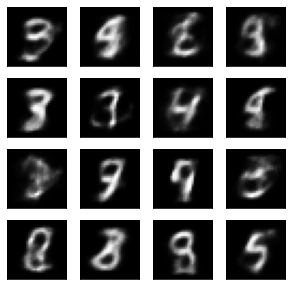

In [26]:
decoder.eval()
fig , axs = plt.subplots(4,4, figsize = (5,5))
with torch.no_grad():
    samples = decoder.sample_distributions(4*4)
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(samples.view(-1,28,28).detach().numpy()[i*4+j], cmap='gray')
            axs[i,j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

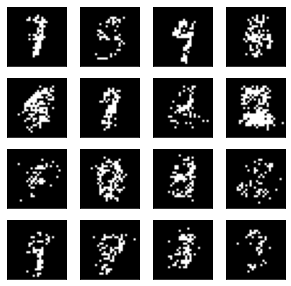

In [27]:
decoder.eval()

fig , axs = plt.subplots(4,4, figsize = (5,5))
with torch.no_grad():
    samples = decoder.sample_images(4*4, argmax=False)
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(samples.detach().view(-1,28,28).numpy()[i*4+j], cmap='gray')
            axs[i,j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

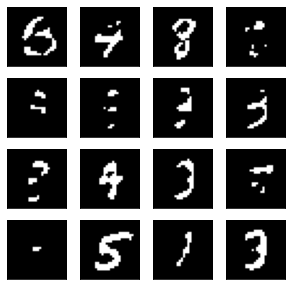

In [28]:
decoder.eval()

fig , axs = plt.subplots(4,4, figsize = (5,5))
with torch.no_grad():
    samples = decoder.sample_images(4*4, argmax=True)
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(samples.detach().view(-1,28,28).numpy()[i*4+j], cmap='gray')
            axs[i,j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

# 4. Turning a Deterministic Auto-Encoder into a generative model


### Architecture and training loop of the auto-encoder

In [29]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        hid = F.relu(self.proj1(batch))
        return self.output(hid)

In [30]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.proj1 = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, batch):
        hid = F.relu(self.proj1(batch))
        output = self.output(hid)
        return output

In [31]:
dim_input = 28*28
latent = 2
hidden_dim = 400
n_epoch = 30
batch_dim = 256

encoder = Encoder(dim_input, hidden_dim, latent)
decoder = Decoder(latent, hidden_dim, dim_input)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) , lr = 1e-3)

for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0
    
    decoder.train()
    encoder.train()
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        optimizer.zero_grad()
        
        batch = train_data_pixels[i:i+batch_dim]

        # We pass the batch through the encoder
        encoded_batch = encoder(batch)

        # We feed the encoded batch straight to the decoder in this case
        # we don't have a KL divergence or any prior for the latent space.
        reconstruction_logits = decoder(encoded_batch)
        
        # We compute the loss
        reconstruction_loss = F.binary_cross_entropy_with_logits(
            reconstruction_logits,
            batch,
            reduction="none"
        ).sum(-1)
        
        # We average the loss because we have batch size of 256
        loss = reconstruction_loss.mean()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        optimizer.step()

    if epoch%5 == 0 :
        print('epoch : ', epoch , '|| loss :' , loss.item())


epoch :  0 || loss : 172.67018127441406
epoch :  5 || loss : 157.08901977539062
epoch :  10 || loss : 151.9066925048828
epoch :  15 || loss : 149.00540161132812
epoch :  20 || loss : 146.7448272705078
epoch :  25 || loss : 145.31350708007812


We can now visualize the latent space of the deterministic auto-encoder.

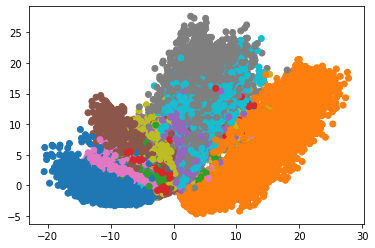

In [32]:
decoder.eval()

# tensor that will contain all latent points
points = np.empty((train_data_pixels.shape[0], 2))
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        batch = train_data_pixels[i:i+batch_dim]
        mu = encoder(batch)
        points[i:i+batch_dim] = mu.numpy()

plt.scatter(
    points[:,0], points[:, 1],
    # colormap is between 0 and 1, and we have 10 classes
    # so we just divide by 10 :)
    # https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
    c=matplotlib.cm.get_cmap("tab10")(train_data_classes.numpy() / 10.)
)
plt.show()

The orange and the gray represent the data points in an elliptical form which looks like a normal distribution, also the blue one looks like an ellipse rotated. So I believe we can approximate this with a GMM.

### Turning the deterministic auto-encoder into a generative model


In [33]:
encoder.eval()
batch_dim = 256

# We transform the training data X to (z1,z2) through
# the encoder only
train_latent_vars = []
with torch.no_grad():
    for i in range(0, train_data_pixels.shape[0], batch_dim): 
        batch = train_data_pixels[i:i+batch_dim]
        encoded_batch = encoder(batch)
        train_latent_vars.append(encoded_batch.numpy())
        
train_latent_vars = np.concatenate(train_latent_vars , axis = 0)

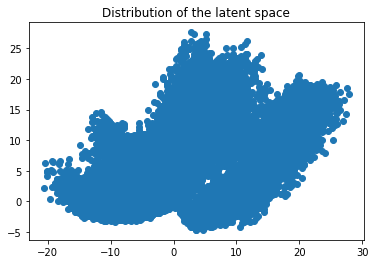

In [34]:
plt.scatter(train_latent_vars[:,0],
            train_latent_vars[:,1])
plt.title("Distribution of the latent space")
plt.show()

In [35]:
from sklearn.mixture import GaussianMixture

# We use 20 components in this example
n_comps = 20

# We fit the GMM using Scikit-Learn library
gm = GaussianMixture(n_components=n_comps).fit(train_latent_vars)
# gm wil contains all the parameters estimated 

Now we will choose a random component (r) and sample from a multivariate gaussian with the parameters ($\mu_r$ and $\Sigma_r$) on this cluster.

Text(0.5, 1.0, 'Distribution of the GMM')

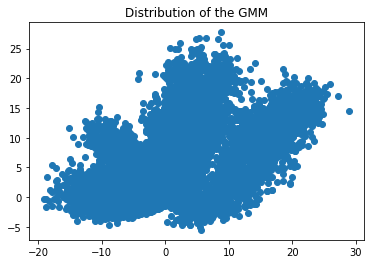

In [36]:
z = np.zeros((20000,2))

for i in range(20000):
  component = np.random.choice(list(range(n_comps)), p=gm.weights_)
  mean_comp = gm.means_[component]
  covs_comp = gm.covariances_[component]
  z[i] = np.random.multivariate_normal(mean_comp , covs_comp).astype('float32')

plt.scatter(z[:,0],z[:,1])
plt.title("Distribution of the GMM")

As we can see it really seems to have the same shape as the real distribution

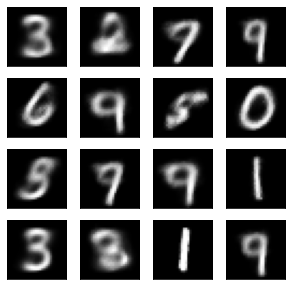

In [37]:
decoder.eval()

fig , axs = plt.subplots(4,4, figsize = (5,5))

with torch.no_grad():
    for i in range(4):
        for j in range(4):
            z_tensor = torch.tensor(z[i*4 + j].astype('float32'))
            out = decoder(z_tensor)
            generated_img = torch.sigmoid(out)
            generated_img = generated_img.view(-1,28,28)
            axs[i,j].imshow(generated_img.detach().numpy()[0], cmap='gray')
            axs[i,j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

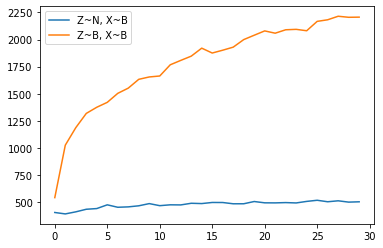

In [38]:
plt.plot(kl_div_1, label = 'Z~N, X~B')
plt.plot(kl_div_2, label = 'Z~B, X~B')
plt.legend(loc="upper left")
plt.show()

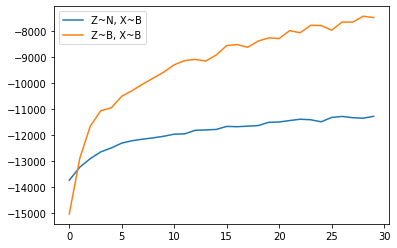

In [39]:
plt.plot(recons_1, label = 'Z~N, X~B')
plt.plot(recons_2, label = 'Z~B, X~B')
plt.legend(loc="upper left")
plt.show()